In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [105]:
#collecting data
texts=pd.read_csv('Data/base_csv_final.csv').drop(47)
d_titles=texts['Title'].to_dict()
l_data=[v for k, v in pd.read_parquet('Data/summary.parquet', engine='pyarrow').groupby('Id')]+[v for k, v in pd.read_parquet('Data/summary_2.parquet', engine='pyarrow').groupby('Id')]

In [26]:
#mean number of words
np.mean([len(df) for df in l_data])

np.float64(4841.666666666667)

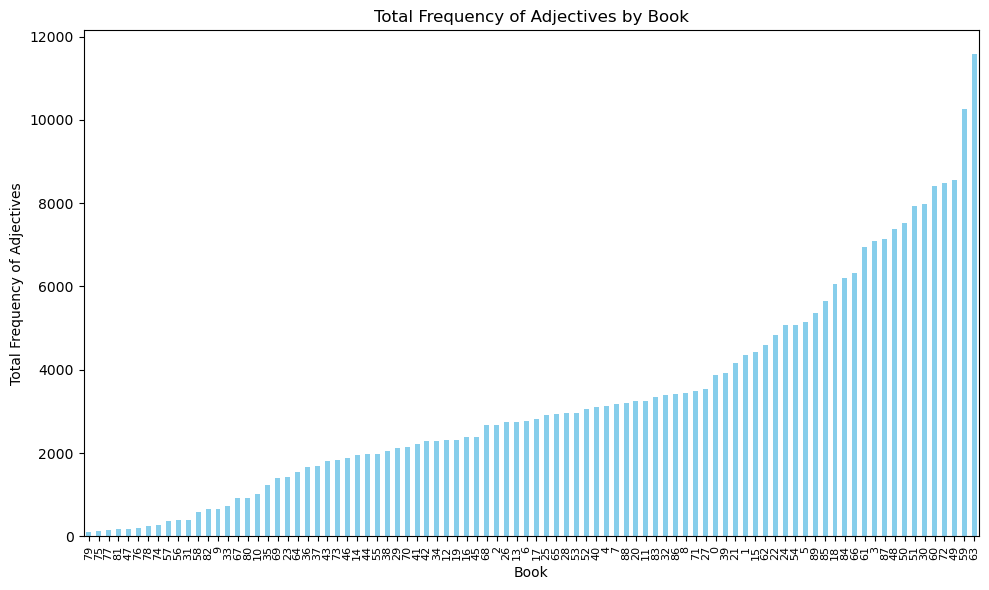

In [30]:
# Step 1: Combine the dataframes into a single dataframe
# Assuming each dataframe has columns: 'word', 'type', 'frequency'
combined_df = pd.concat(l_data, ignore_index=True)

# Step 2: Filter the combined dataframe to only include adjectives
# Assuming the 'type' column indicates the word type (e.g., 'ADJ' for adjectives)
adjectives_df = combined_df[combined_df['Type'] == 'adj']

# Step 3: Sum the frequency of adjectives for each book
# Assuming each dataframe has a 'book' column that identifies the book
# If not, you can add a column to each dataframe identifying the book before concatenation
adjectives_by_book = adjectives_df.groupby('Id')['Count'].sum()

# Step 4: Plot the results
plt.figure(figsize=(10, 6))

adjectives_by_book.sort_values().plot(kind='bar', color='skyblue')
#adjectives_dict = {d_titles.get(book_id, book_id): freq for book_id, freq in adjectives_by_book.items()}
#plt.bar(adjectives_dict.keys(), adjectives_dict.values(), color='skyblue')

# Customizing the plot
plt.title('Total Frequency of Adjectives by Book')
plt.xlabel('Book')
plt.ylabel('Total Frequency of Adjectives')
plt.xticks(rotation=90, ha='center',fontsize=8)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()


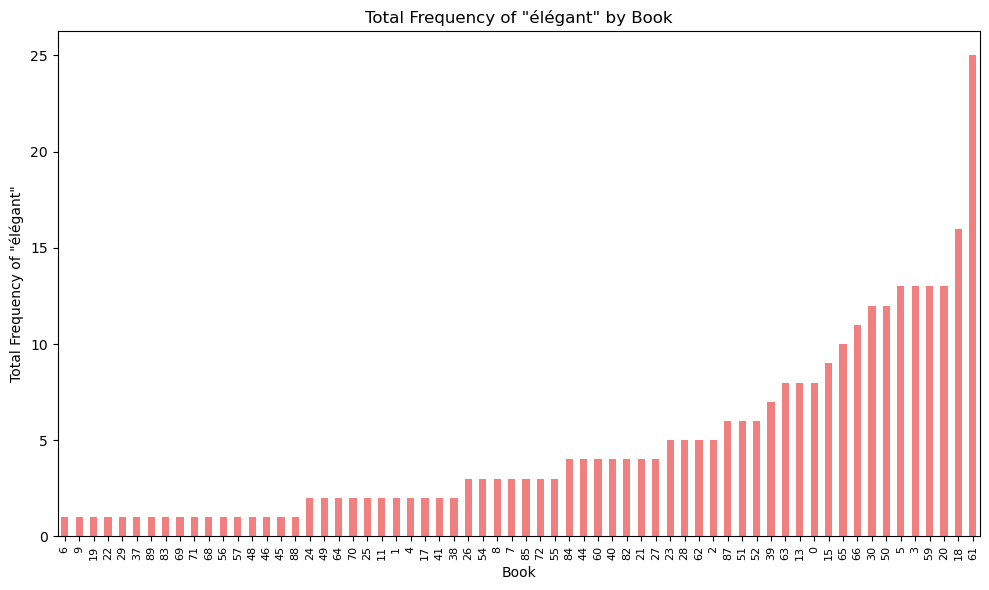

In [34]:
combined_df = pd.concat(l_data, ignore_index=True)

# Step 2: Filter the combined dataframe to only include the word "beautiful"
word_of_interest = "élégant"
word_df = combined_df[combined_df['Word'] == word_of_interest]

# Step 3: Sum the frequency of the word for each book
frequency_by_book = word_df.groupby('Id')['Count'].sum()

# Step 4: Plot the results
plt.figure(figsize=(10, 6))
frequency_by_book.sort_values().plot(kind='bar', color='lightcoral')

# Customizing the plot
plt.title(f'Total Frequency of "{word_of_interest}" by Book')
plt.xlabel('Book')
plt.ylabel(f'Total Frequency of "{word_of_interest}"')
plt.xticks(rotation=90, ha='center',fontsize=8)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()


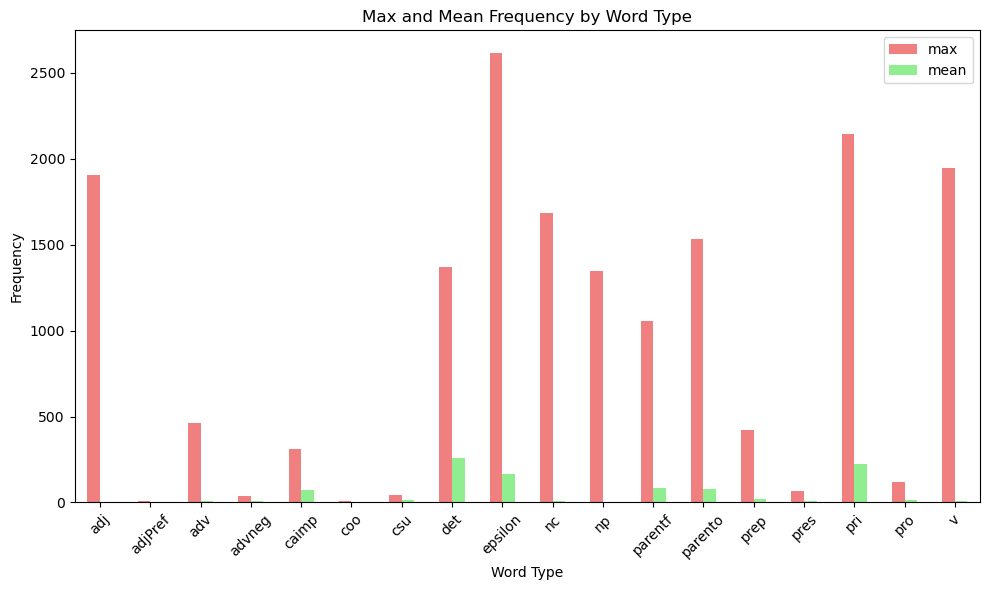

<Figure size 1000x600 with 0 Axes>

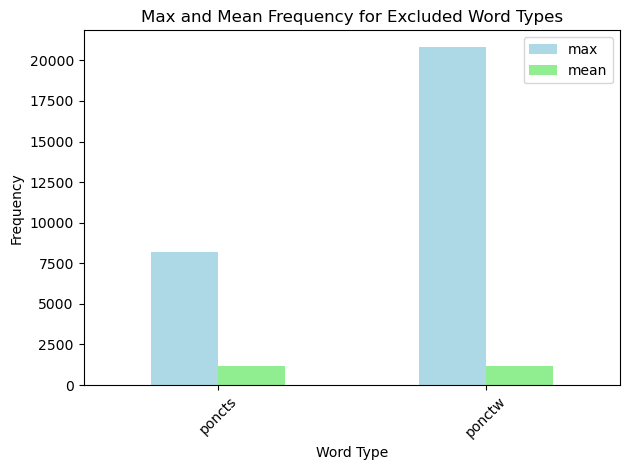

In [40]:
combined_df = pd.concat(l_data, ignore_index=True)

# Step 2: Group by word type and calculate min, max, and mean frequencies
type_stats = combined_df.groupby('Type')['Count'].agg(['max', 'mean'])

excluded_types = ['ponctw', 'poncts']

# Filter out the types you want to exclude from the main plot
filtered_type_stats = type_stats[~type_stats.index.isin(excluded_types)]

# Filter out the excluded types for separate plotting
excluded_type_stats = type_stats[type_stats.index.isin(excluded_types)]
# Step 3: Plot the results
filtered_type_stats.plot(kind='bar', figsize=(10, 6), color=['lightcoral', 'lightgreen'])

# Customizing the plot
plt.title('Max and Mean Frequency by Word Type')
plt.xlabel('Word Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

plt.figure(figsize=(10, 6))
excluded_type_stats.plot(kind='bar', color=['lightblue', 'lightgreen'])

plt.title('Max and Mean Frequency for Excluded Word Types')
plt.xlabel('Word Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot for excluded types
plt.show()

) missing from font(s) DejaVu Sans.37: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) DejaVu Sans.ages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


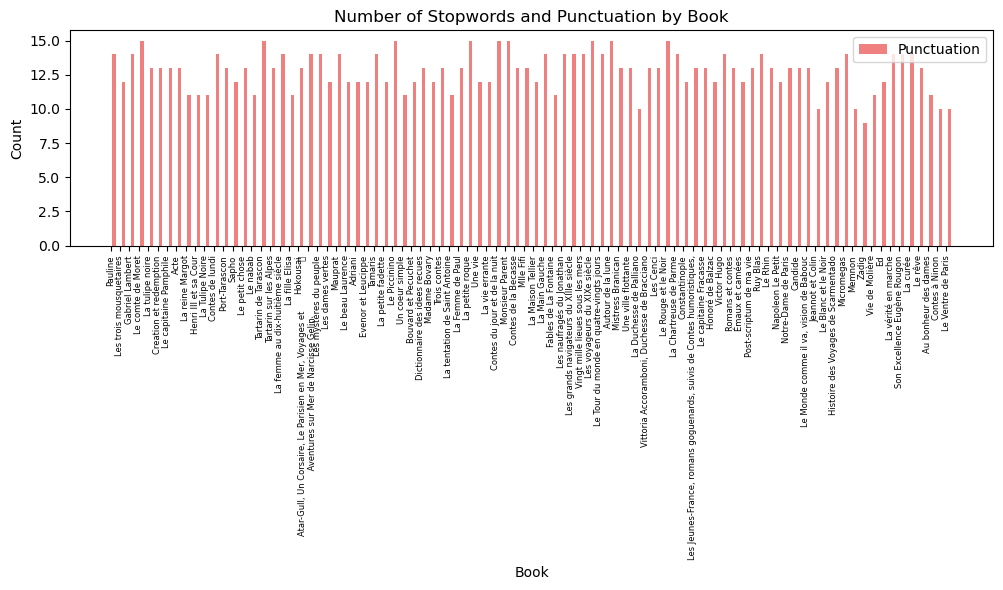

In [87]:
#pb car 47 vide probablement
import spacy
combined_df = pd.concat(l_data, ignore_index=True)

nlp = spacy.load("fr_core_news_sm")  #modèle français
stop_words_fr = nlp.Defaults.stop_words #liste de stopwords fr

# Step 2: Define a function to count stopwords and punctuation
def count_stopwords_punctuation(df, punctuation_types):
    punctuation_count = df[df['Type'].isin(punctuation_types)].shape[0]
    return punctuation_count

# Step 3: Count stopwords and punctuation for each dataframe (book)
punctuation_count = []
books = d_titles.values()

for df in l_data:
    punctuation_count_value = count_stopwords_punctuation(df, ["epsilon","ponctw","poncts","parento","parentf"])
    punctuation_count.append(punctuation_count_value)

# Step 4: Plot the results

# Bar plot for stopwords and punctuation counts
x = range(len(l_data))
width = 0.35  # The width of the bars

plt.figure(figsize=(10, 6))
plt.bar([p + width for p in x], punctuation_count, width, label='Punctuation', color='lightcoral')

# Customizing the plot
plt.title('Number of Stopwords and Punctuation by Book')
plt.xlabel('Book')
plt.ylabel('Count')
plt.xticks(ticks=range(len(books)), labels=books,rotation=90,fontsize=6)  # Position x-ticks at the center of bars
plt.legend()

plt.tight_layout()

# Show the plot
plt.show()


) missing from font(s) DejaVu Sans.34: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) DejaVu Sans.ages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


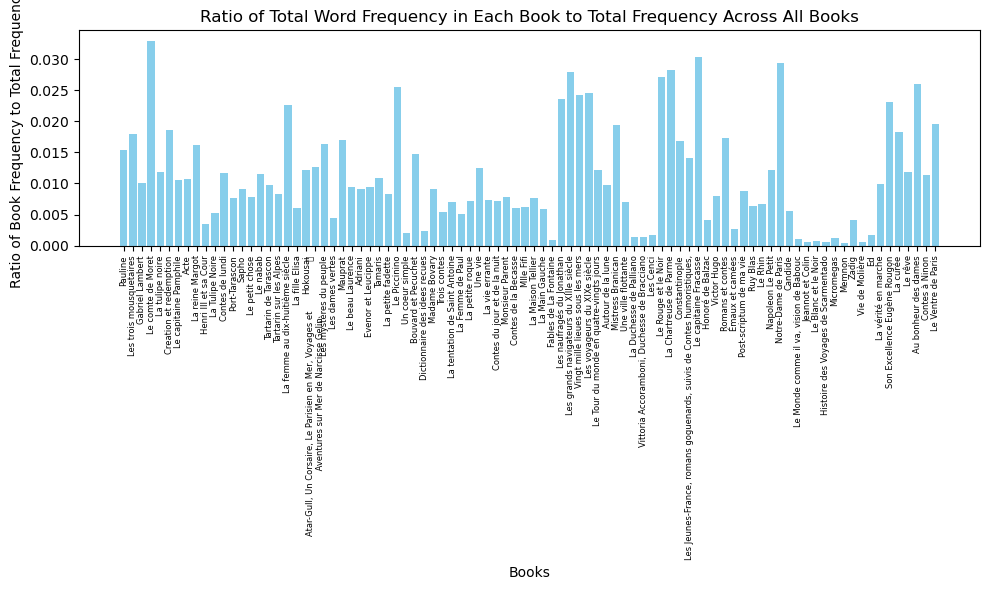

In [62]:
# Calculate the total frequency (sum of all frequencies in all books)
total_frequency = 0
word_counts = []  # List to store the word counts (ratios) for each book

# Step 1: Calculate the total frequency (sum of all frequencies in all books)
for df in l_data:
    total_frequency += df['Count'].sum()

# Step 2: Calculate the ratio for each book (number of words in each book / total frequency)
book_titles = list(d_titles.values())  # Assuming you have a dictionary of book titles

for df in l_data:
    # Number of words in each book is the length of the dataframe (since each word appears once)
    num_words = len(df)
    
    # Total frequency for each book
    total_freq_for_book = df['Count'].sum()
    
    # Calculate the ratio (total frequency for the book / total frequency across all books)
    ratio = total_freq_for_book / total_frequency
    word_counts.append(ratio)

# Step 3: Plot the ratio data
plt.figure(figsize=(10, 6))
plt.bar(book_titles, word_counts, color='skyblue')

# Customizing the plot
plt.title('Ratio of Total Word Frequency in Each Book to Total Frequency Across All Books')
plt.xlabel('Books')
plt.ylabel('Ratio of Book Frequency to Total Frequency')
plt.xticks(rotation=90, fontsize=6)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()


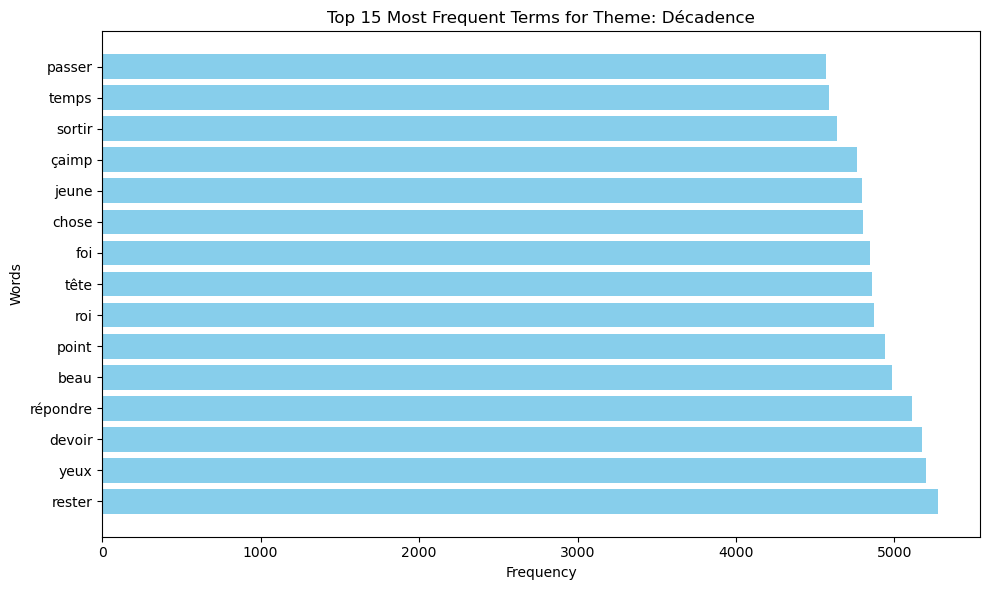

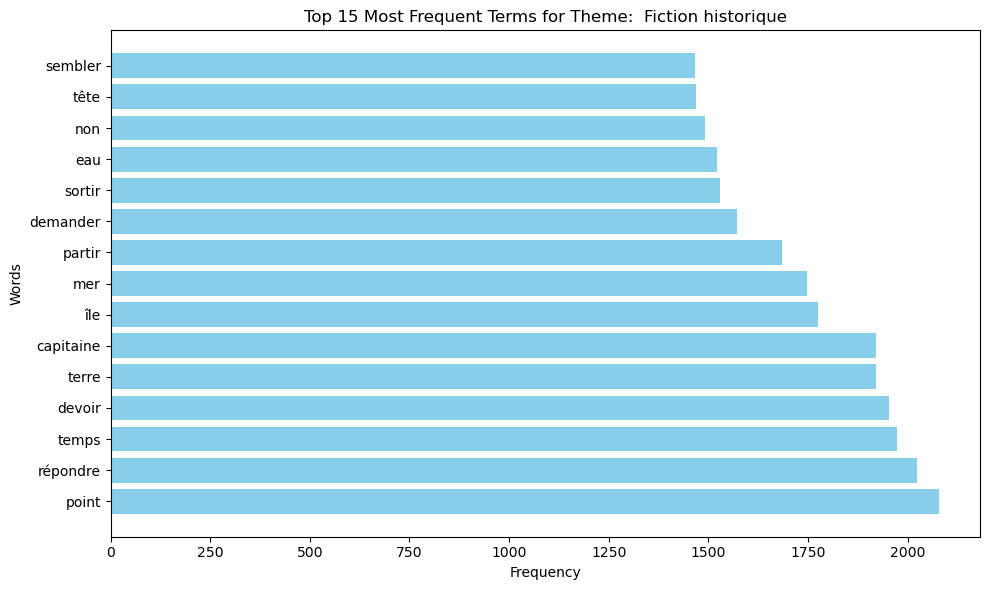

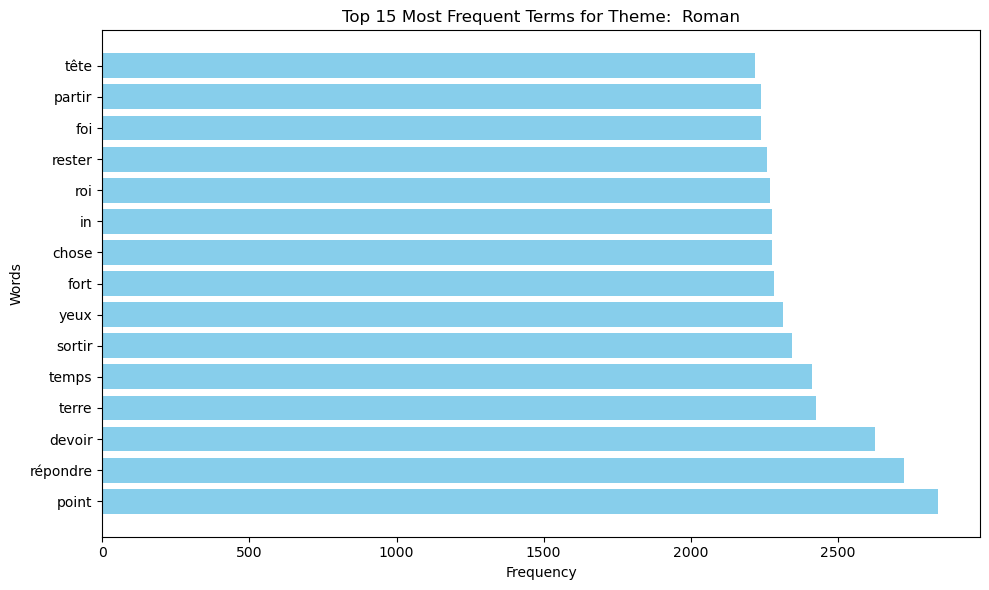

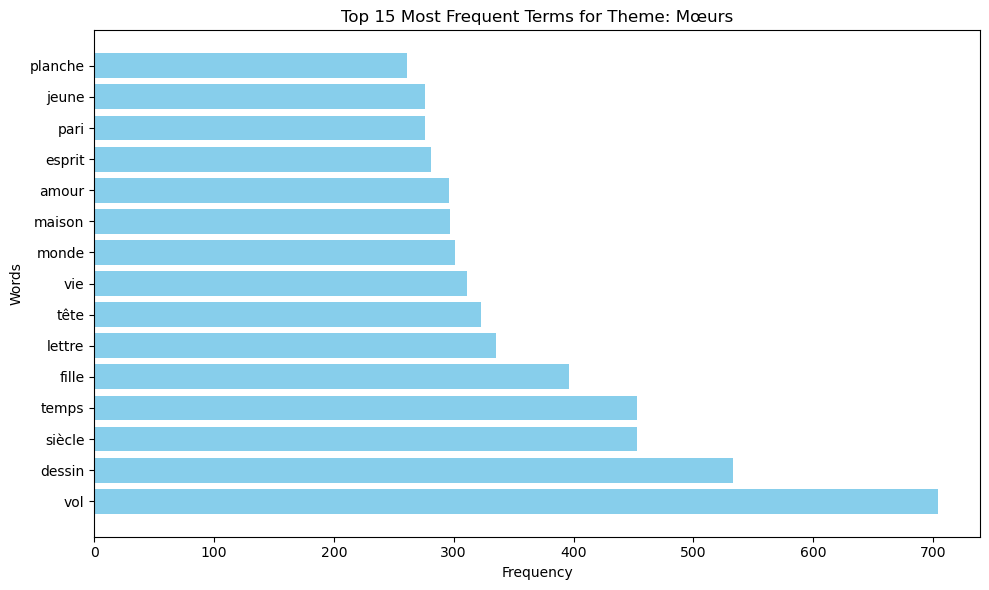

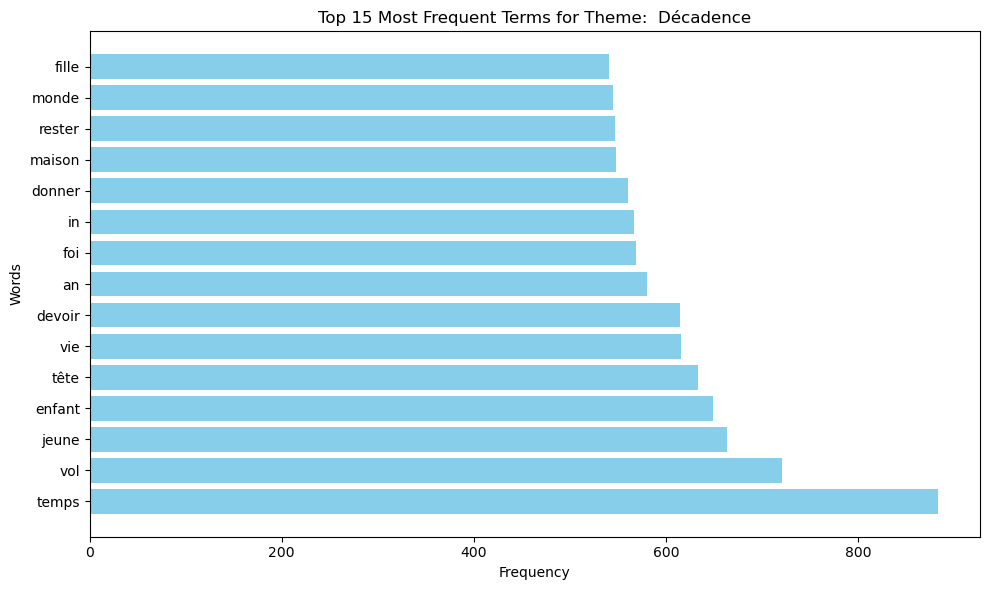

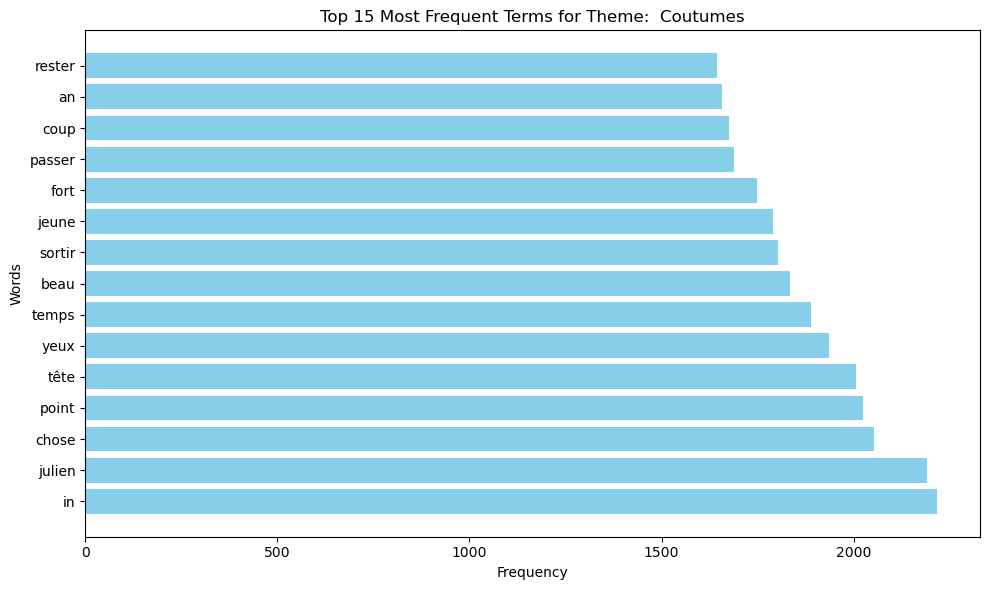

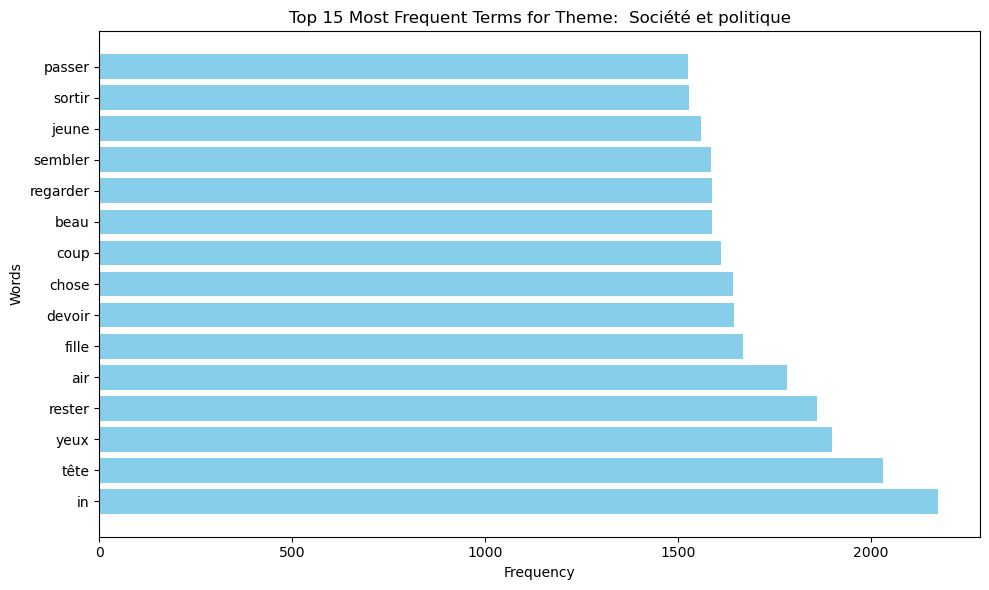

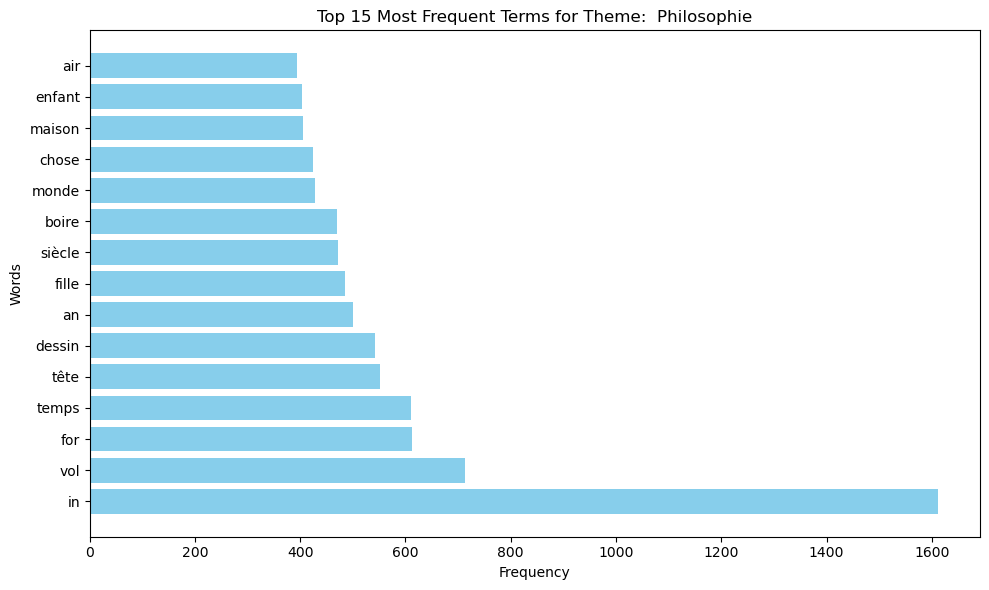

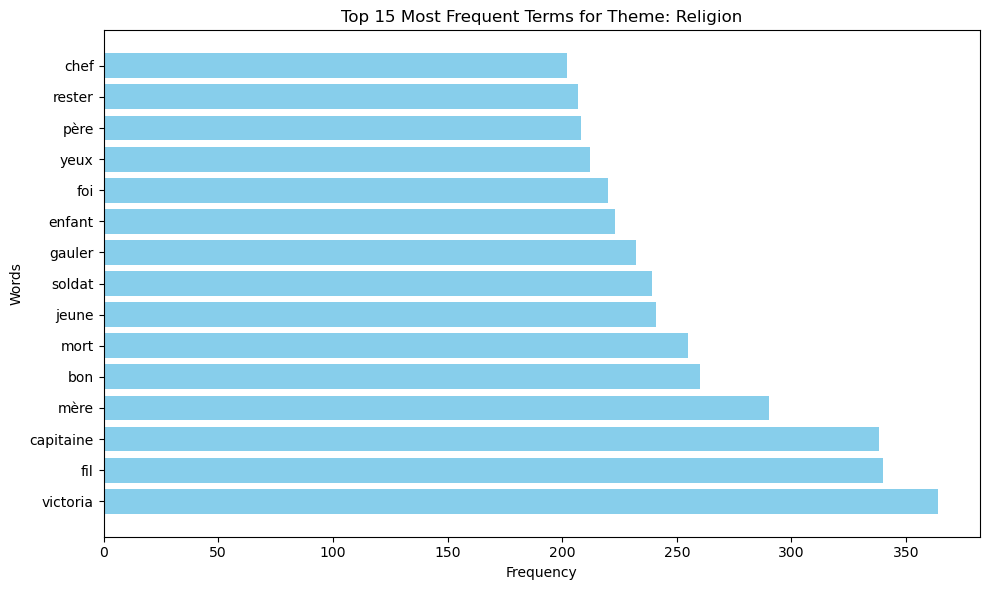

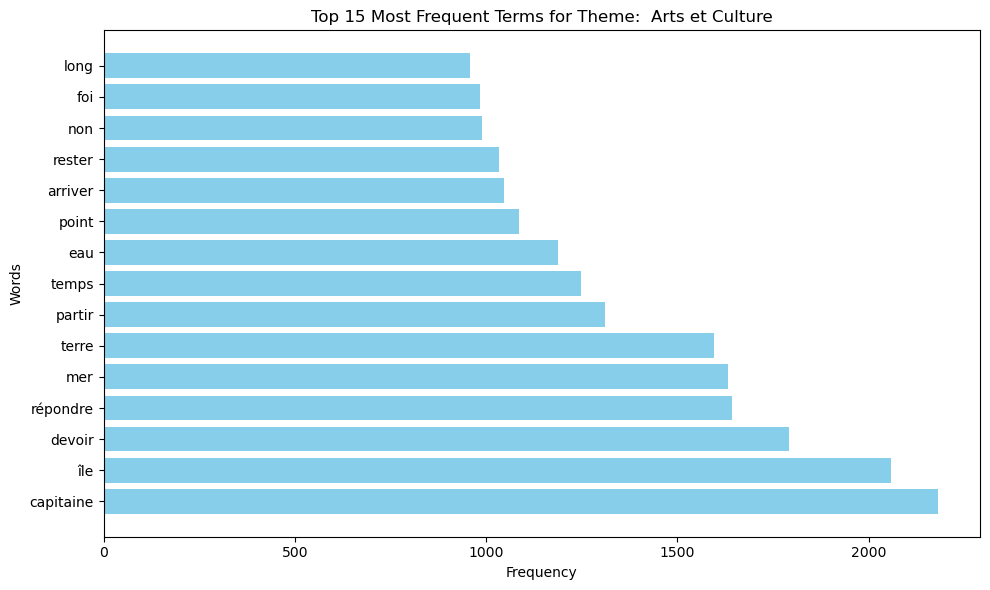

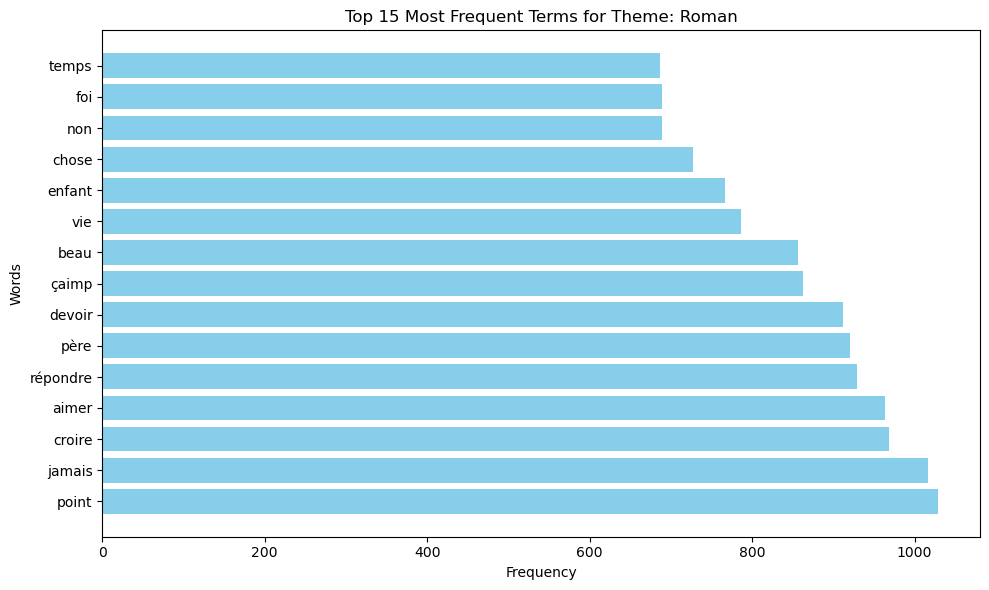

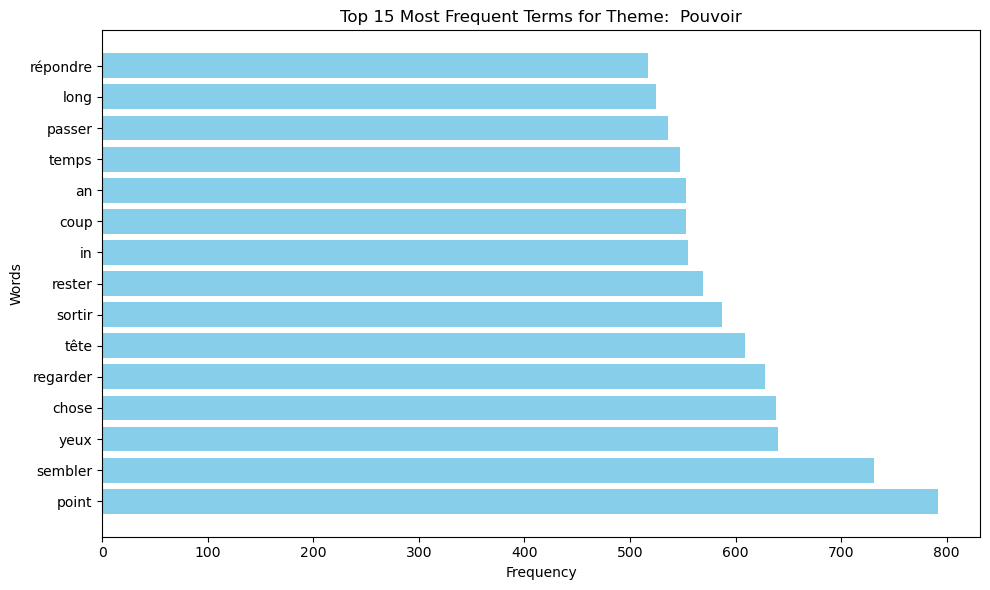

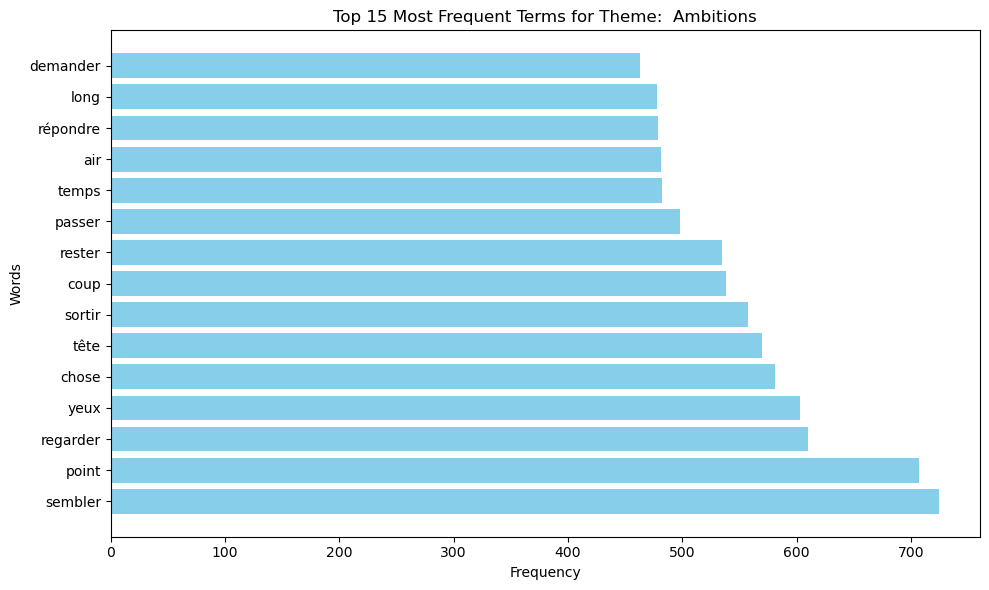

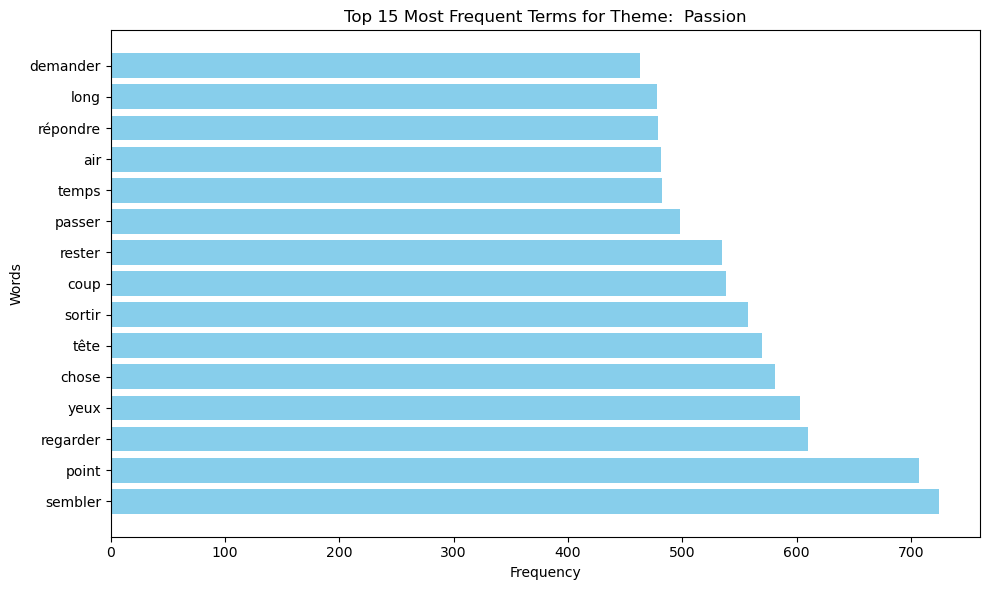

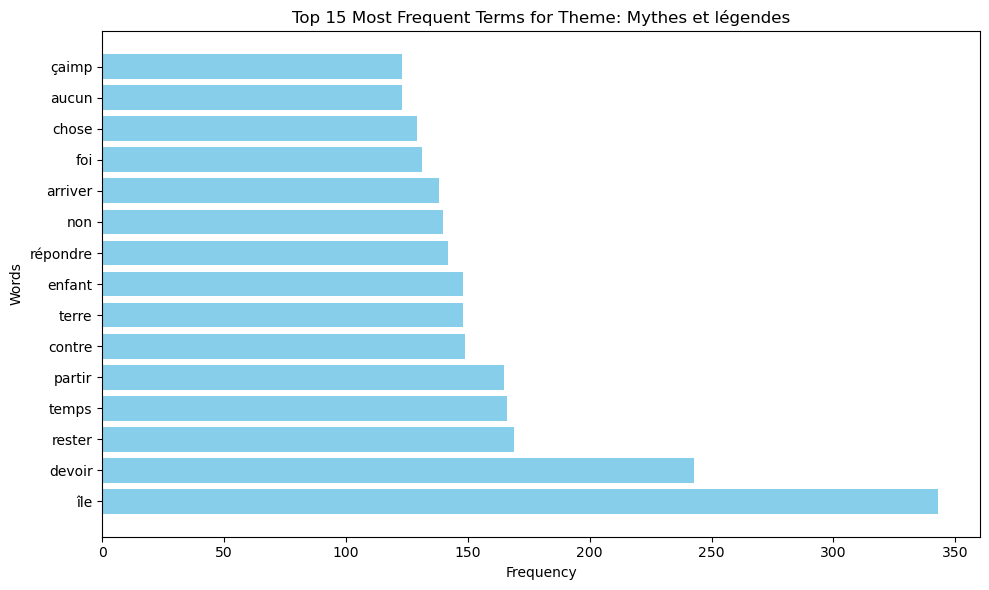

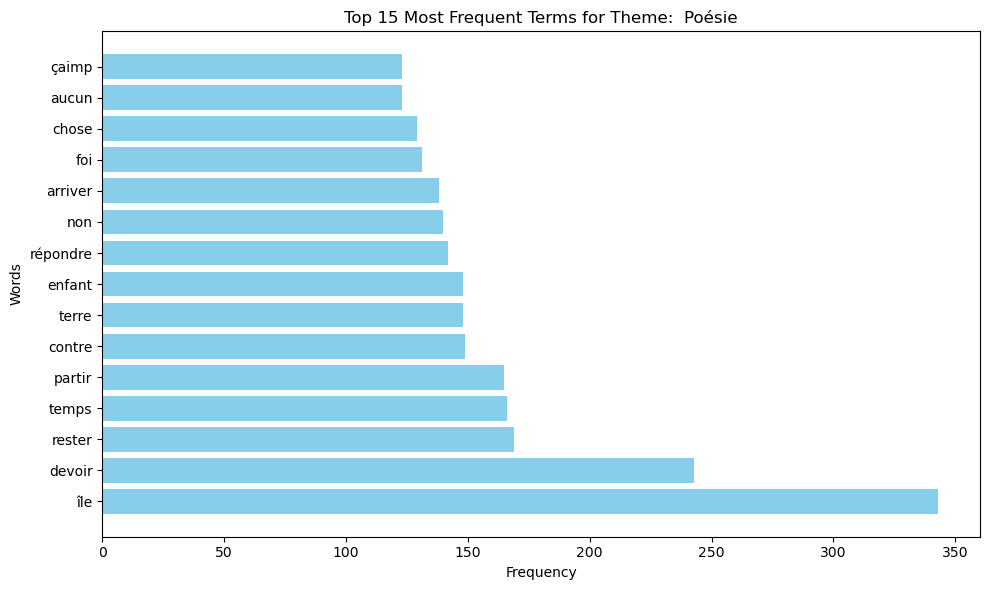

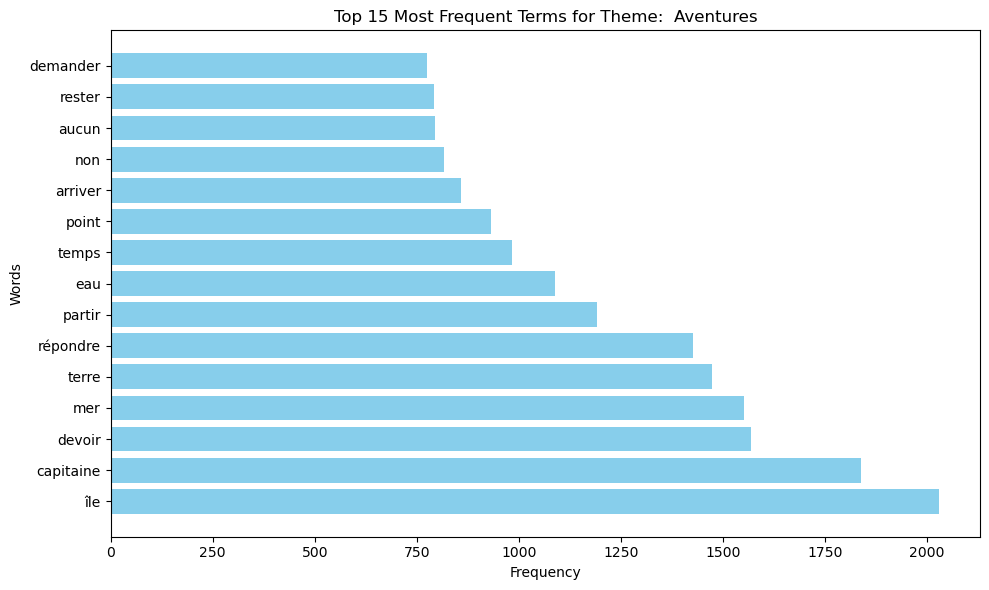

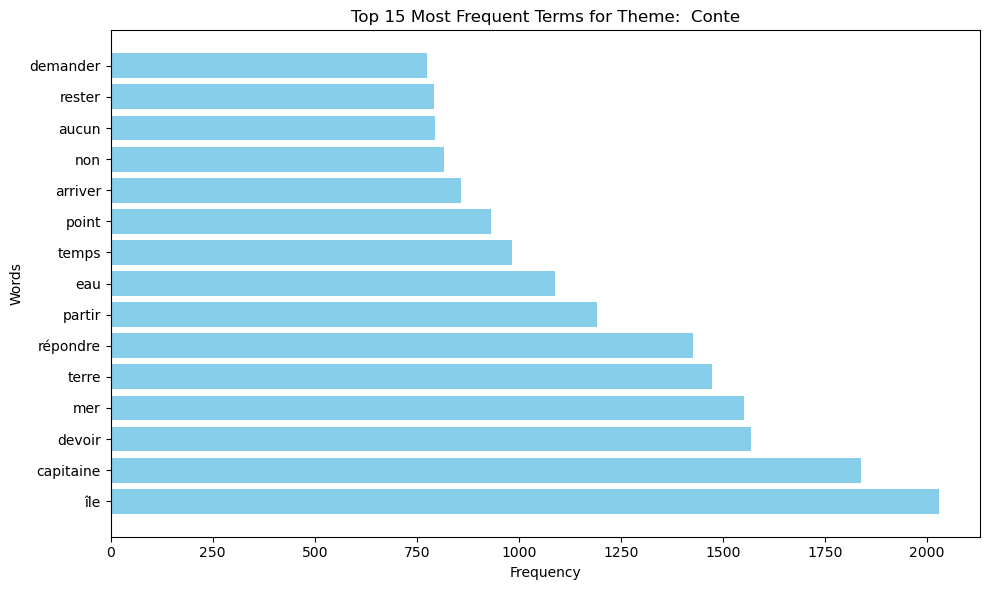

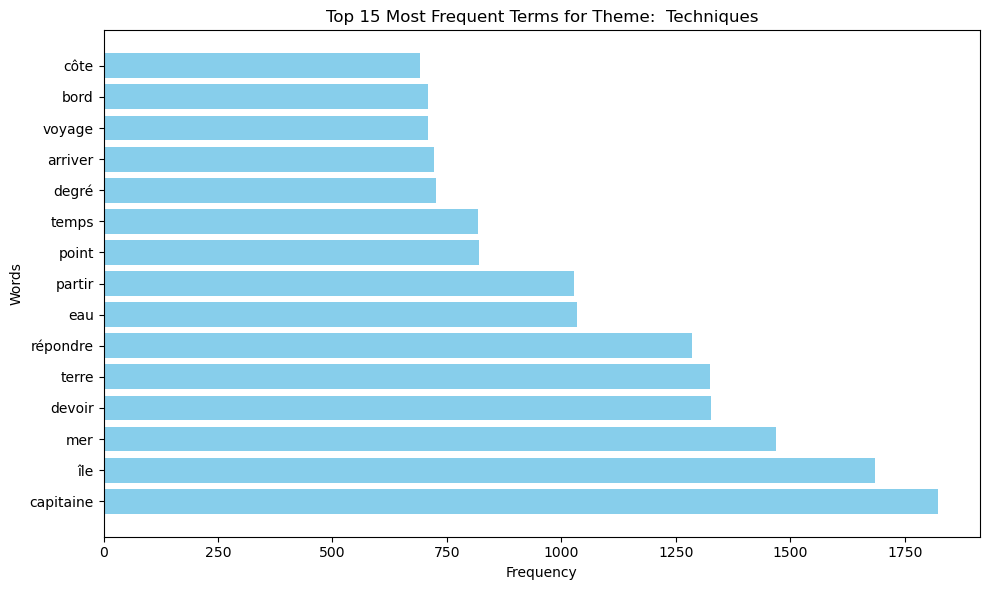

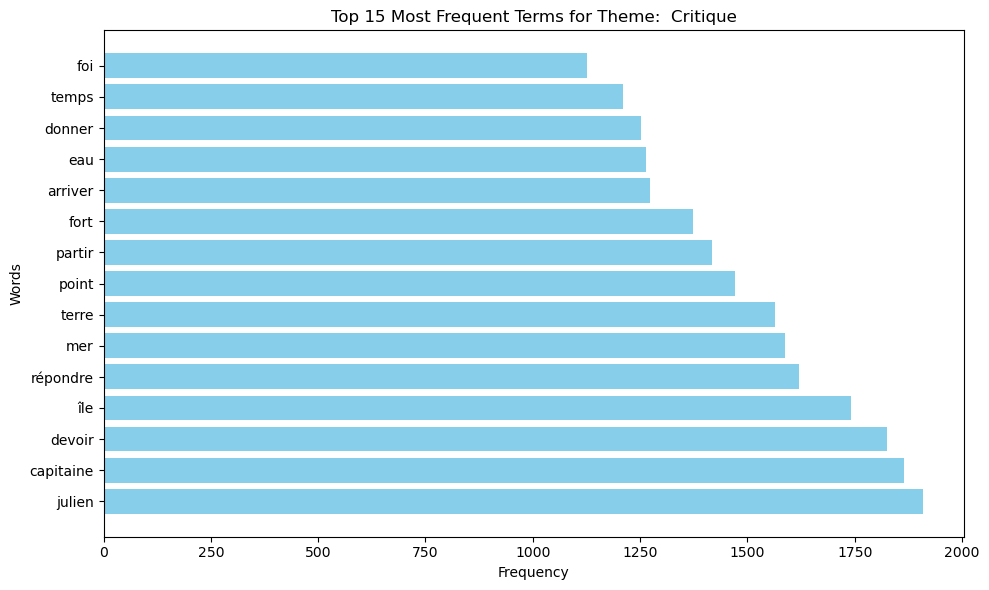

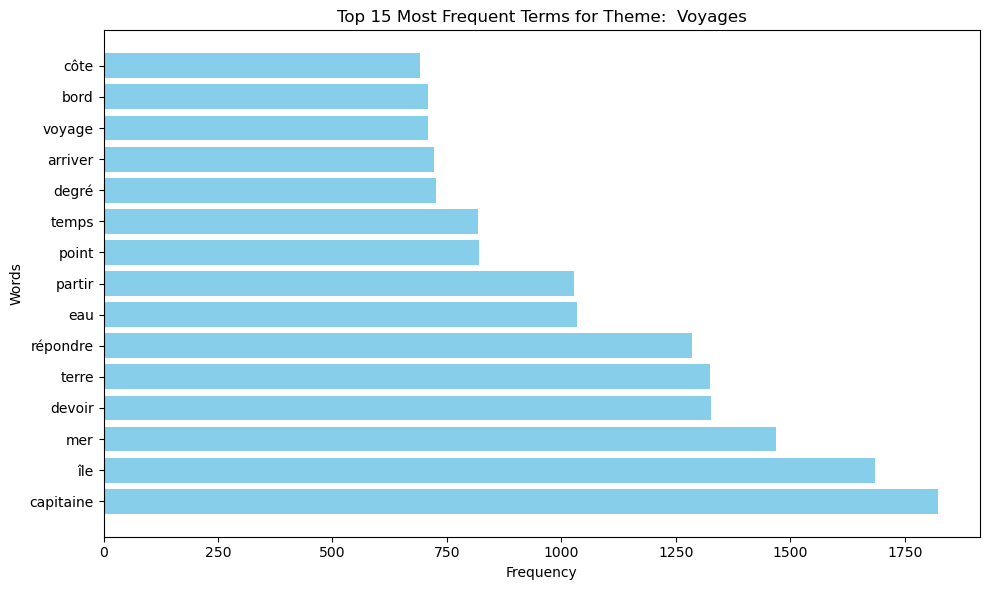

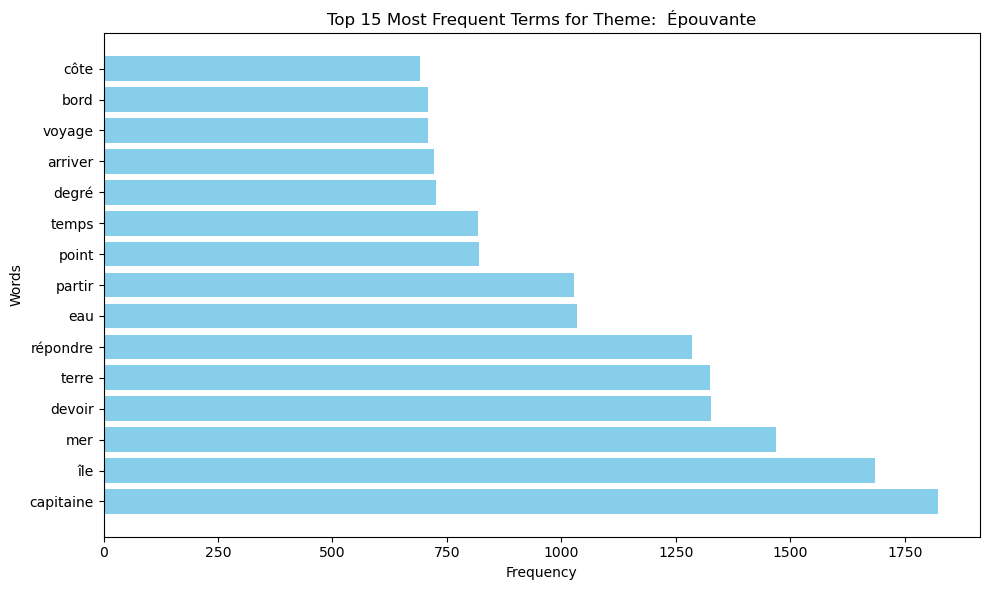

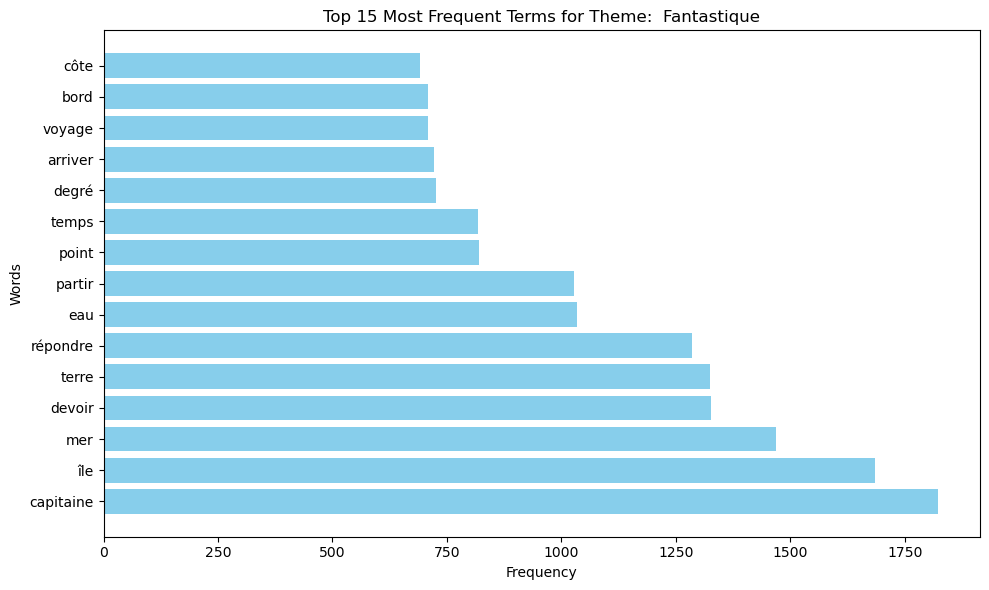

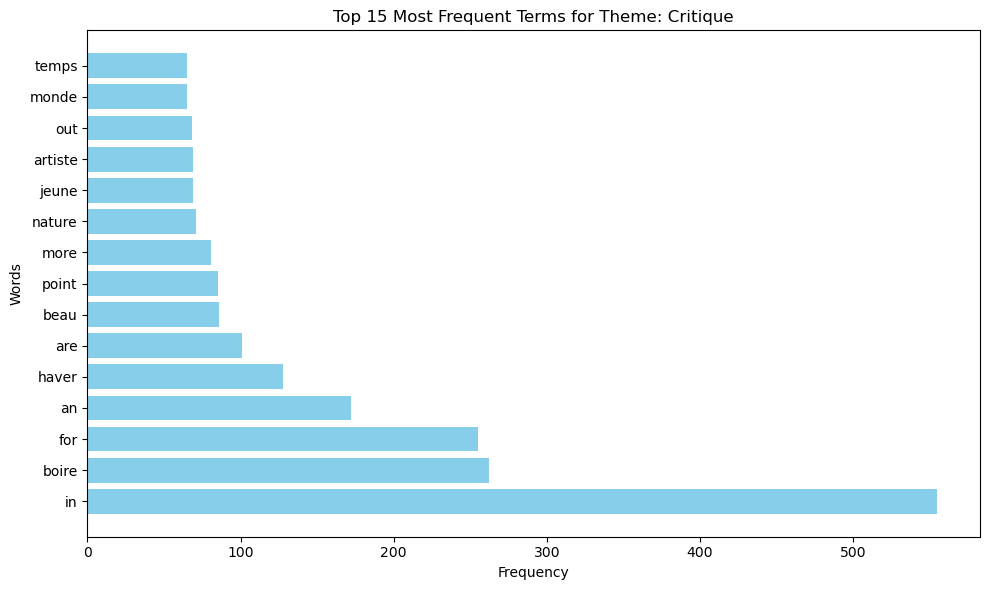

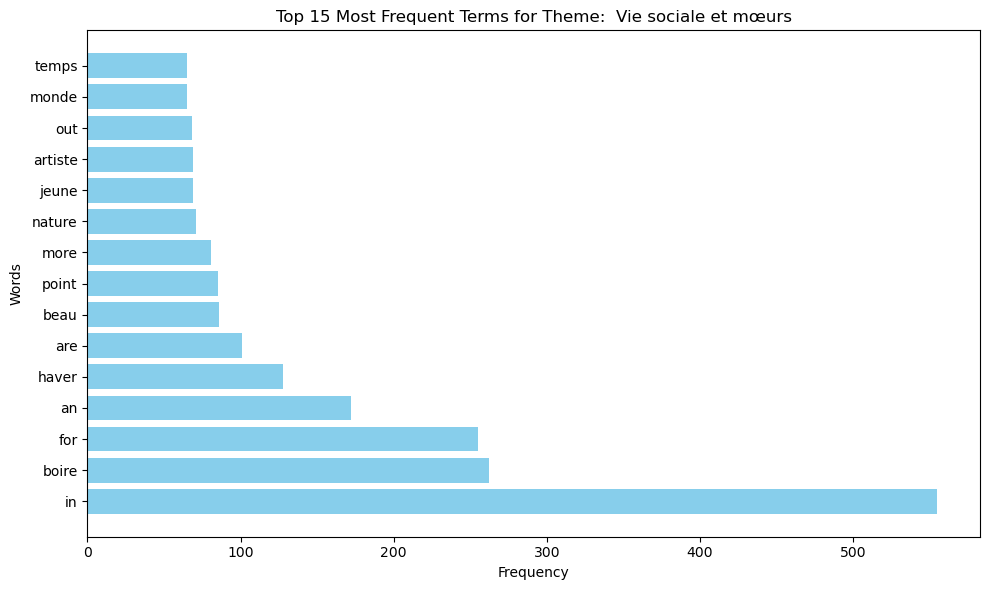

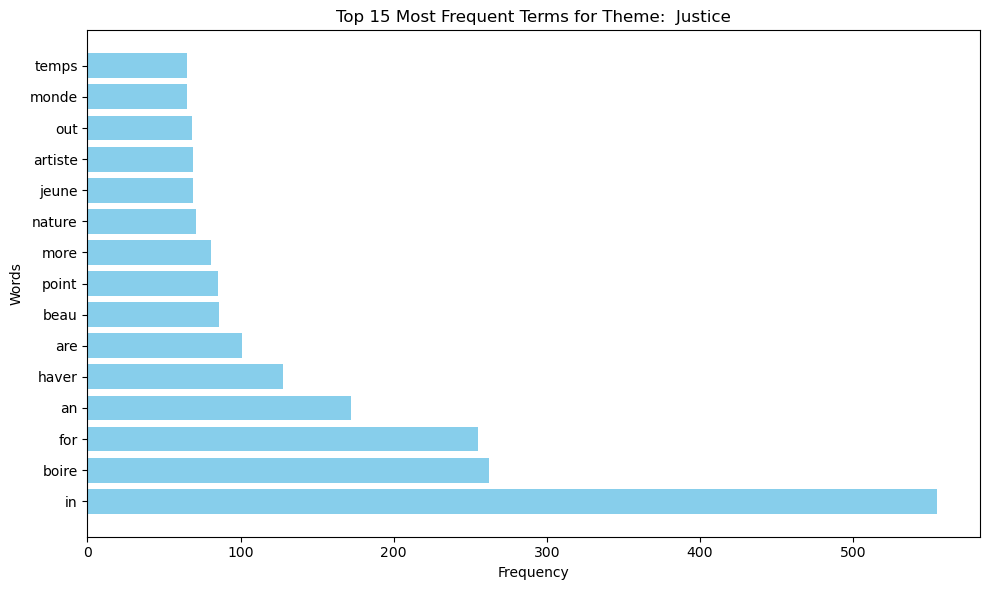

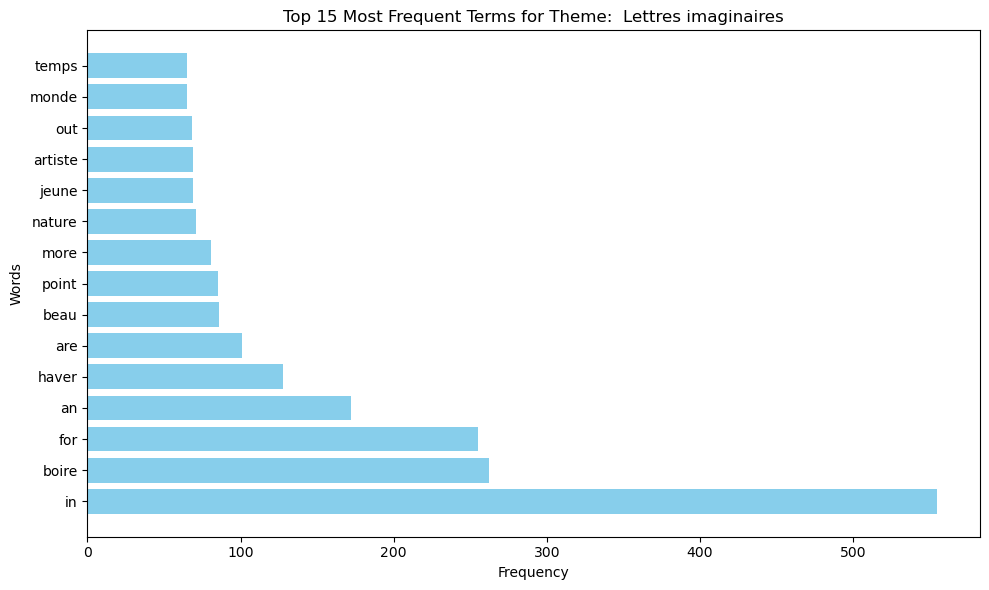

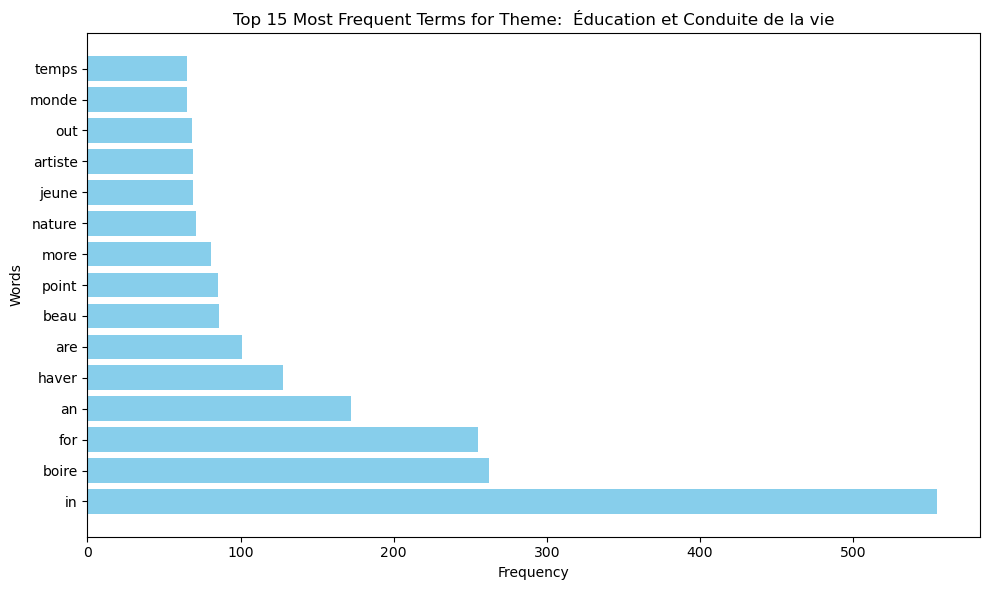

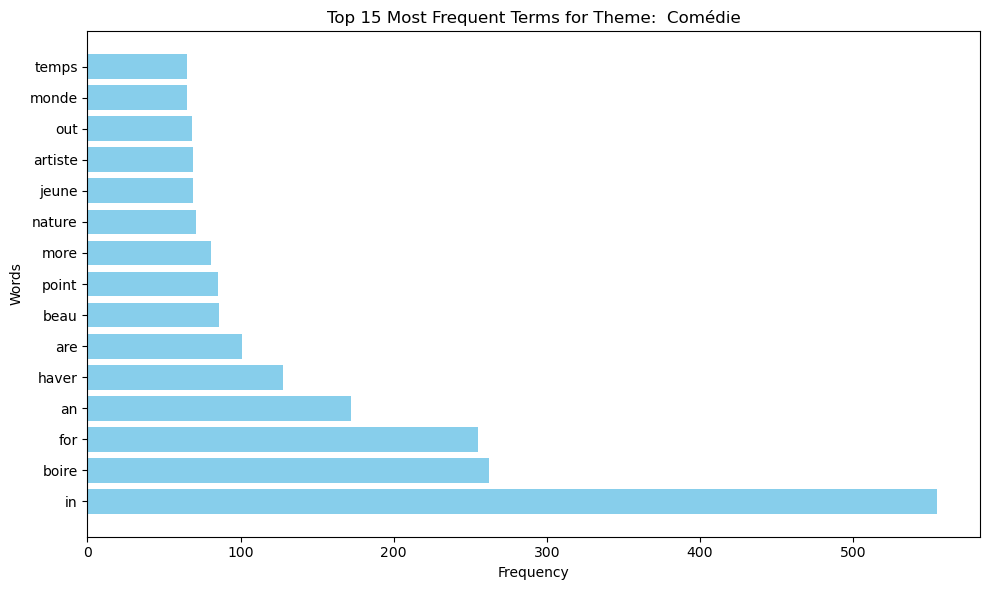

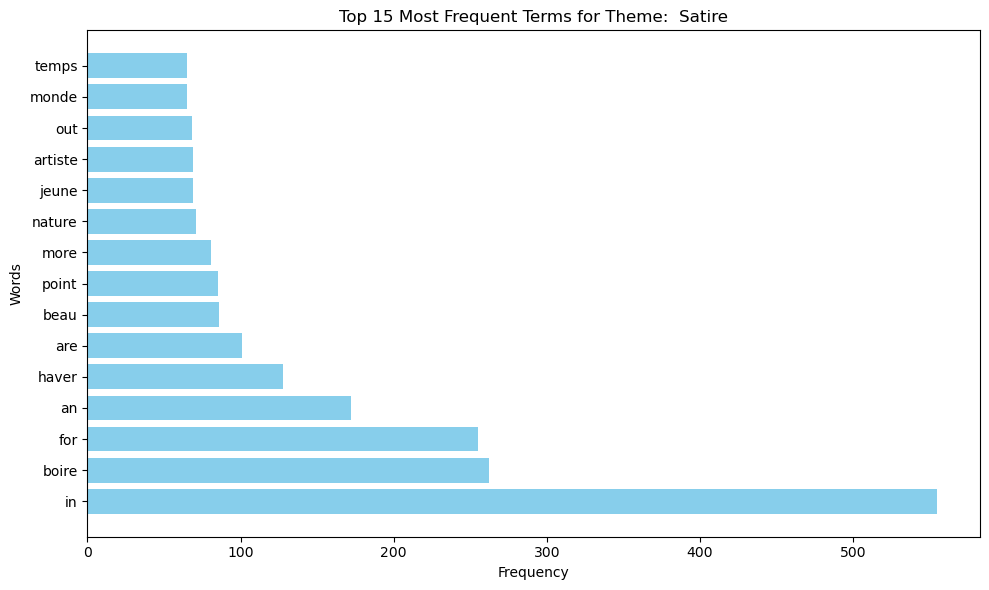

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict


# Step 1: Create a dictionary to store word frequencies for each theme
theme_word_freq = defaultdict(lambda: defaultdict(int))

# Set the types of words you want to exclude (e.g., 'punctuation' and 'stopword')
exclude_types = ["epsilon", "ponctw", "poncts", "parento", "parentf", "np"]

# Step 2: Calculate the total word frequencies across all books to identify the top 20 most frequent words
total_word_freq = defaultdict(int)

for idx, row in texts.iterrows():
    book_title = row['Title']
    themes = row['Themes'].split(',')  #split list
    
    # Ensure that idx is within the bounds of l_data
    if idx < len(l_data):
        book_df = l_data[idx]  # Use the index to get the corresponding book's word frequencies dataframe
        
        # Get the words, frequencies, and types from the respective columns
        words = book_df['Word']
        frequencies = book_df['Count']
        types = book_df['Type']
        
        # Update total word frequency for all words across all books
        for word, freq, word_type in zip(words, frequencies, types):
            if word_type not in exclude_types:  # Only consider valid types
                total_word_freq[word] += freq

# Step 3: Get the top 20 most frequent words across all books
top_20_words = {word for word, freq in sorted(total_word_freq.items(), key=lambda x: x[1], reverse=True)[:30]}

# Step 4: Calculate word frequencies for each theme across all books, excluding top 20 frequent words
for idx, row in texts.iterrows():
    book_title = row['Title']
    themes = row['Themes'].split(',')
    
    # Ensure that idx is within the bounds of l_data
    if idx < len(l_data):
        book_df = l_data[idx]  # Use the index to get the corresponding book's word frequencies dataframe
        
        # Get the words, frequencies, and types from the respective columns
        words = book_df['Word']
        frequencies = book_df['Count']
        types = book_df['Type']
        
        # For each theme, add the word frequencies to the theme's frequency dictionary
        for theme in themes:
            for word, freq, word_type in zip(words, frequencies, types):  # Map words, frequencies, and types
                if word_type not in exclude_types and word not in top_20_words:  # Exclude top 20 frequent words
                    try:
                        # Ensure freq is a numeric value (convert to int or float if necessary)
                        freq = float(freq)  # Convert freq to float if it's not already a number
                        theme_word_freq[theme][word] += freq
                    except ValueError:
                        # Handle case where freq is not a number (e.g., if it contains a string or NaN)
                        print(f"Warning: Invalid frequency value for word '{word}' in book '{book_title}'")
                        continue
    else:
        print(f"Warning: No corresponding word frequency data for book '{book_title}' (idx={idx})")

# Step 5: Plot the 15 most frequent terms for each theme, excluding top 20 words
for theme, word_freqs in theme_word_freq.items():
    # Sort words by frequency (descending)
    sorted_words = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)[:15]
    
    # Prepare data for plotting
    words, freqs = zip(*sorted_words)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(words, freqs, color='skyblue')
    plt.title(f"Top 15 Most Frequent Terms for Theme: {theme}")
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.tight_layout()
    plt.show()
